In [14]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import LearningRateScheduler
%matplotlib inline

In [35]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
def train_windows(df, ref_day, predict_day):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=(shape[1], shape[2]), return_sequences=True, dropout=0.2))
    model.add(LSTM(64, return_sequences=True, dropout=0.2))

    # model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(7,activation='linear'))
    model.add(Dense(7))
    model.compile(loss="mae", optimizer="Adam",metrics=['mae'])
    model.summary()
    return model
def scheduler(epoch):
    #change the learning rate at whether epoch you like
    if epoch > 100:
        lr = 1e-4/2
        return lr
    elif epoch > 30:
        lr = 1e-4
        return lr
    else:
        lr = 1e-3
        return lr
    return lr

In [48]:
train = pd.read_csv('電力備轉容量20202.csv')
train[-20:]

,日期,備轉容量,臺北最高氣溫(℃),臺北最低氣溫(℃),新北最高氣溫(℃),新北最低氣溫(℃),高雄最高氣溫(℃),高雄最低氣溫(℃)
434,20210310,3055.0,21.3,17.5,21.8,17.9,24.6,19.5
435,20210311,3077.0,27.5,18.7,27.7,18.6,25.0,20.2
436,20210312,3272.0,23.5,18.5,24.3,17.9,26.4,20.3
437,20210313,3075.0,21.5,17.7,22.4,17.7,24.9,20.6
438,20210314,2933.0,23.4,18.4,24.3,18.4,25.6,20.0
439,20210315,3074.0,28.9,18.0,29.1,16.1,26.8,20.2
440,20210316,3087.0,30.0,19.1,30.0,17.2,27.7,21.1
441,20210317,3183.0,26.0,20.3,25.7,18.5,30.2,21.8
442,20210318,3214.0,24.9,19.5,25.6,19.0,27.0,22.3
443,20210319,3137.0,26.8,19.9,27.5,19.0,27.1,22.9


In [49]:
train['y'] = train['備轉容量'].shift(-7)
train['臺北最低氣溫(℃)'] = train['臺北最低氣溫(℃)'].shift(-7)
train['新北最低氣溫(℃)'] = train['新北最低氣溫(℃)'].shift(-7)
train['高雄最低氣溫(℃)'] = train['高雄最低氣溫(℃)'].shift(-7)
train['臺北最高氣溫(℃)'] = train['臺北最高氣溫(℃)'].shift(-7)
train['新北最高氣溫(℃)'] = train['新北最高氣溫(℃)'].shift(-7)
train['高雄最高氣溫(℃)'] = train['高雄最高氣溫(℃)'].shift(-7)
# train = type_result(train)
# train.iloc[:,1:5] = normalize(train.iloc[:,1:5])
train.iloc[:,1:8] = normalize(train.iloc[:,1:8])
# train[-20:]
# # target
target = train[len(train.values)-14:len(train.values)-7]
train = train.dropna()
del target['y']
target

,日期,備轉容量,臺北最高氣溫(℃),臺北最低氣溫(℃),新北最高氣溫(℃),新北最低氣溫(℃),高雄最高氣溫(℃),高雄最低氣溫(℃)
440,20210316,0.157016,0.378738,0.264957,0.437500,0.339207,0.441315,0.446154
441,20210317,0.191119,0.345515,0.350427,0.402778,0.427313,0.582160,0.497436
442,20210318,0.202131,0.411960,0.350427,0.472222,0.427313,0.582160,0.497436
443,20210319,0.174778,0.544850,0.478632,0.576389,0.515419,0.629108,0.548718
444,20210320,0.068917,0.544850,0.478632,0.576389,0.559471,0.629108,0.548718
445,20210321,0.192185,0.677741,0.521368,0.680556,0.559471,0.723005,0.651282
446,20210322,0.128597,0.611296,0.564103,0.645833,0.603524,0.723005,0.651282


In [50]:
test = train[-150:]
#train & test
train = train.reset_index()
test = test.reset_index()
target = target.reset_index()
train = train.dropna()

In [51]:
train.drop(['日期', 'index'], axis=1, inplace=True)
test.drop(['日期', 'index'], axis=1, inplace=True)
target.drop(['日期', 'index'], axis=1, inplace=True)

In [52]:
target

,備轉容量,臺北最高氣溫(℃),臺北最低氣溫(℃),新北最高氣溫(℃),新北最低氣溫(℃),高雄最高氣溫(℃),高雄最低氣溫(℃)
0,0.157016,0.378738,0.264957,0.437500,0.339207,0.441315,0.446154
1,0.191119,0.345515,0.350427,0.402778,0.427313,0.582160,0.497436
2,0.202131,0.411960,0.350427,0.472222,0.427313,0.582160,0.497436
3,0.174778,0.544850,0.478632,0.576389,0.515419,0.629108,0.548718
4,0.068917,0.544850,0.478632,0.576389,0.559471,0.629108,0.548718
5,0.192185,0.677741,0.521368,0.680556,0.559471,0.723005,0.651282
6,0.128597,0.611296,0.564103,0.645833,0.603524,0.723005,0.651282


In [47]:
train.head()

,備轉容量,臺北最高氣溫(℃),臺北最低氣溫(℃),新北最高氣溫(℃),新北最低氣溫(℃),高雄最高氣溫(℃),高雄最低氣溫(℃),y
0,0.051510,0.411960,0.414530,0.357639,0.436123,0.563380,0.492308,3235.0
1,0.154529,0.475083,0.418803,0.482639,0.444934,0.502347,0.430769,3131.0
2,0.262522,0.601329,0.491453,0.618056,0.515419,0.525822,0.461538,3298.0
3,0.352043,0.491694,0.457265,0.489583,0.444934,0.563380,0.466667,3851.0
4,0.017762,0.305648,0.324786,0.295139,0.339207,0.488263,0.379487,3091.0


In [281]:
test.head()

,備轉容量,臺北最高氣溫(℃),臺北最低氣溫(℃),新北最高氣溫(℃),新北最低氣溫(℃),高雄最高氣溫(℃),高雄最低氣溫(℃),y
0,0.482416,0.564784,0.623932,0.552083,0.660793,0.718310,0.774359,4215.0
1,0.442984,0.591362,0.576923,0.597222,0.607930,0.690141,0.702564,3719.0
2,0.490231,0.671096,0.662393,0.715278,0.696035,0.741784,0.615385,3569.0
3,0.304796,0.621262,0.662393,0.631944,0.718062,0.732394,0.630769,3523.0
4,0.268917,0.508306,0.508547,0.545139,0.555066,0.718310,0.666667,3189.0


In [54]:
X_train, Y_train = train_windows(train, 7, 7)
X_test, Y_test = train_windows(test, 7, 7)

In [80]:
tar_X = []
for i in range(0,7):
    tar_X.append(target.values[i].tolist())
Rtar_X = []
Rtar_X.append(tar_X)
tar_X = np.array(Rtar_X)
tar_X[0]

array([[0.15701599, 0.37873754, 0.26495726, 0.4375    , 0.33920705,
        0.44131455, 0.44615385],
       [0.19111901, 0.34551495, 0.35042735, 0.40277778, 0.42731278,
        0.58215962, 0.4974359 ],
       [0.20213144, 0.41196013, 0.35042735, 0.47222222, 0.42731278,
        0.58215962, 0.4974359 ],
       [0.17477798, 0.5448505 , 0.47863248, 0.57638889, 0.5154185 ,
        0.62910798, 0.54871795],
       [0.06891652, 0.5448505 , 0.47863248, 0.57638889, 0.55947137,
        0.62910798, 0.54871795],
       [0.19218472, 0.67774086, 0.52136752, 0.68055556, 0.55947137,
        0.72300469, 0.65128205],
       [0.1285968 , 0.61129568, 0.56410256, 0.64583333, 0.60352423,
        0.72300469, 0.65128205]])

In [78]:
X_train[0]

array([[0.05150977, 0.41196013, 0.41452991, 0.35763889, 0.43612335,
        0.56338028, 0.49230769],
       [0.15452931, 0.47508306, 0.41880342, 0.48263889, 0.44493392,
        0.50234742, 0.43076923],
       [0.2625222 , 0.6013289 , 0.49145299, 0.61805556, 0.5154185 ,
        0.5258216 , 0.46153846],
       [0.35204263, 0.49169435, 0.45726496, 0.48958333, 0.44493392,
        0.56338028, 0.46666667],
       [0.01776199, 0.30564784, 0.32478632, 0.29513889, 0.33920705,
        0.48826291, 0.37948718],
       [0.12930728, 0.34219269, 0.3034188 , 0.32638889, 0.32599119,
        0.47887324, 0.33333333],
       [0.16305506, 0.39202658, 0.38461538, 0.37847222, 0.34361233,
        0.64788732, 0.37948718]])

In [62]:
X_train.shape

(426, 7, 7)

In [63]:
model = lstm_stock_model(X_train.shape)
change_lr = LearningRateScheduler(scheduler)
callback = [EarlyStopping(monitor="mae", patience=10, verbose=1, mode="auto"), change_lr]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             18432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
flatten (Flatten)            (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3143      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
Total params: 54,655
Trainable params: 54,655
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=16, validation_split=0.2, shuffle=False)

 val_mae: 454.0793
Epoch 59/200
22/22 [==============================] - 0s 6ms/step - loss: 440.8841 - mae: 440.8841 - val_loss: 439.9312 - val_mae: 439.9312
Epoch 60/200
22/22 [==============================] - 0s 7ms/step - loss: 437.8892 - mae: 437.8892 - val_loss: 436.6508 - val_mae: 436.6508
Epoch 61/200
22/22 [==============================] - 0s 7ms/step - loss: 433.5209 - mae: 433.5209 - val_loss: 431.3174 - val_mae: 431.3174
Epoch 62/200
22/22 [==============================] - 0s 6ms/step - loss: 435.3426 - mae: 435.3426 - val_loss: 429.7492 - val_mae: 429.7492
Epoch 63/200
22/22 [==============================] - 0s 7ms/step - loss: 431.9848 - mae: 431.9848 - val_loss: 432.6122 - val_mae: 432.6122
Epoch 64/200
22/22 [==============================] - 0s 6ms/step - loss: 434.1963 - mae: 434.1963 - val_loss: 447.1708 - val_mae: 447.1708
Epoch 65/200
22/22 [==============================] - 0s 6ms/step - loss: 435.1657 - mae: 435.1657 - val_loss: 461.1902 - val_mae: 461.1902
E

No handles with labels found to put in legend.


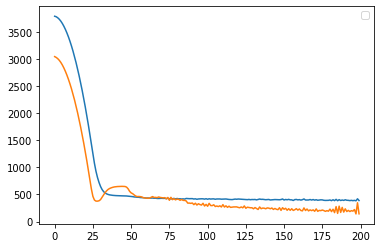

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(loc = 'upper right')

In [66]:
print(X_test[0])
print('\n')
print(X_test[10])

[[0.51225577 0.52491694 0.61111111 0.52777778 0.63876652 0.69014085
  0.64615385]
 [0.46216696 0.59136213 0.64529915 0.63888889 0.68722467 0.72300469
  0.68205128]
 [0.660746   0.66112957 0.68376068 0.69444444 0.73127753 0.73239437
  0.76923077]
 [0.56802842 0.62790698 0.71367521 0.69097222 0.76651982 0.76995305
  0.75384615]
 [0.23587922 0.64119601 0.74358974 0.65625    0.79735683 0.74647887
  0.75384615]
 [0.60248668 0.53156146 0.7008547  0.55902778 0.75770925 0.79342723
  0.80512821]
 [0.48241563 0.56478405 0.62393162 0.55208333 0.66079295 0.71830986
  0.77435897]]


[[0.26891652 0.50830565 0.50854701 0.54513889 0.55506608 0.71830986
  0.66666667]
 [0.29307282 0.51162791 0.50854701 0.52777778 0.55066079 0.65258216
  0.67692308]
 [0.37726465 0.5448505  0.62393162 0.55902778 0.63436123 0.68544601
  0.71794872]
 [0.55772647 0.72093023 0.67094017 0.71875    0.72687225 0.65258216
  0.68205128]
 [0.38152753 0.7641196  0.68376068 0.77777778 0.65638767 0.66197183
  0.70769231]
 [0.32824156 

In [67]:
print(model.predict(X_test)[134])
print('\n')
print(model.predict(X_test)[100])

[3069.9226 3075.5034 3075.065  3085.7715 3084.144  3090.783  3093.2812]


[3187.2905 3193.1829 3192.5342 3203.711  3202.048  3208.9182 3211.5342]


In [68]:
print(Y_test[0])
print('\n')
print(Y_test[10])

[3719. 3569. 3523. 3189. 3551. 3319. 3263.]


[3590. 3708. 3190. 3373. 3364. 3463. 3147.]


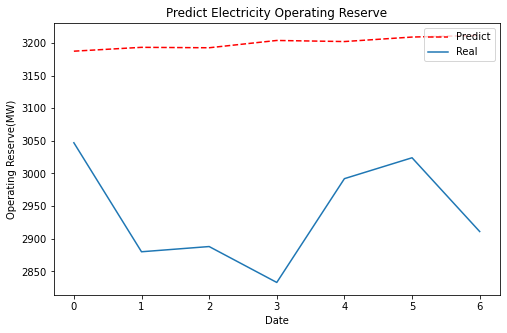

In [69]:
plt.figure(num=3, figsize=(8, 5),)
plt.plot(model.predict(X_test)[100], color='red', linestyle='--', label='Predict')
plt.plot(Y_test[100], label='Real')
plt.title('Predict Electricity Operating Reserve')
plt.xlabel('Date')
plt.ylabel('Operating Reserve(MW)')
plt.legend(loc = 'upper right')

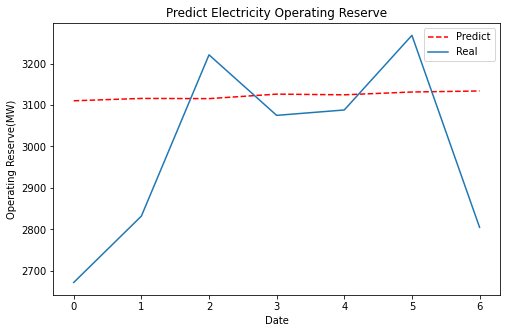

In [70]:
plt.figure(num=3, figsize=(8, 5),)
plt.plot(model.predict(X_test)[120], color='red', linestyle='--', label='Predict')
plt.plot(Y_test[120], label='Real')
plt.title('Predict Electricity Operating Reserve')
plt.xlabel('Date')
plt.ylabel('Operating Reserve(MW)')
plt.legend(loc = 'upper right')

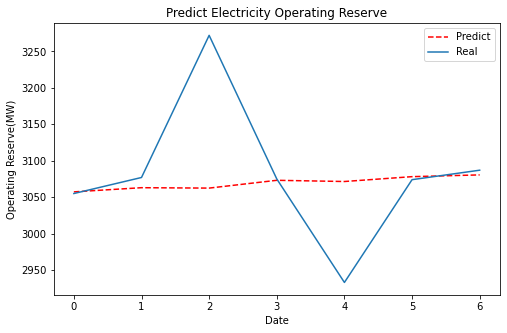

In [71]:
plt.figure(num=3, figsize=(8, 5),)
plt.plot(model.predict(X_test)[130], color='red', linestyle='--', label='Predict')
plt.plot(Y_test[130], label='Real')
plt.title('Predict Electricity Operating Reserve')
plt.xlabel('Date')
plt.ylabel('Operating Reserve(MW)')
plt.legend(loc = 'upper right')

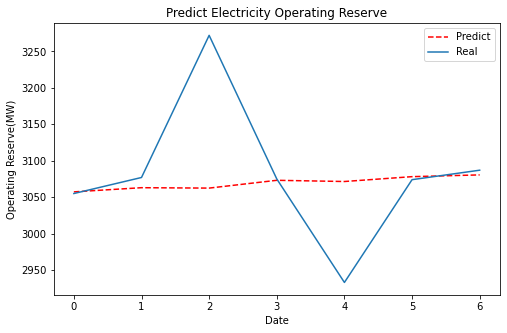

In [72]:
plt.figure(num=3, figsize=(8, 5),)
plt.plot(model.predict(X_test)[130], color='red', linestyle='--', label='Predict')
plt.plot(Y_test[130], label='Real')
plt.title('Predict Electricity Operating Reserve')
plt.xlabel('Date')
plt.ylabel('Operating Reserve(MW)')
plt.legend(loc = 'upper right')

In [104]:
result = pd.DataFrame(model.predict(tar_X)[0].tolist())

In [105]:

result.insert(0, "date", [20210323,20210324,20210325,20210326,20210327,20210328,20210329], True) 
result.columns =['Date', 'Predict Result'] 
result.to_csv('g.csv')

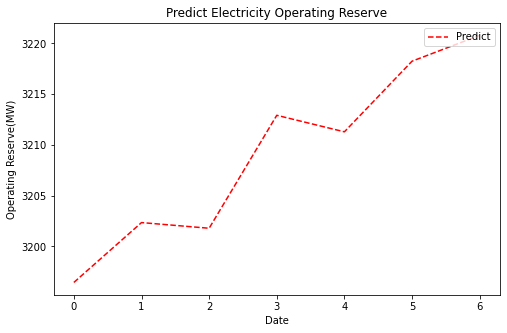

In [82]:
# real test
plt.figure(num=3, figsize=(8, 5),)
plt.plot(model.predict(tar_X)[0], color='red', linestyle='--', label='Predict')
# plt.plot(info_Y, label='Real')
plt.title('Predict Electricity Operating Reserve')
plt.xlabel('Date')
plt.ylabel('Operating Reserve(MW)')
plt.legend(loc = 'upper right')